# Лабораторная 4

## Визуализировать KL(q|p), KL(p|q), 0.5 KL(q|p) + 0.5 KL (p|q) для вариационного вывода в зависимости от количества итераций оптимизации.  Выборка: MNIST, Fashion-MNIST, CIFAR-10 или любая другая, используемая в DL. Модель: произвольная нейросеть. Вариационное распределение: нормальное с диагональной матрицей ковариаций.

**Сеть взята отсюда:** [github](https://github.com/AugusteLef/BayesianNeuralNetworks/tree/f7032069f2307896e140a490272f4915ad9a8932) \
**Датасет: MNIST**

In [ ]:

!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz #train images
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz #train labels
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz #test images
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz #test labels
!pip install idx2numpy

--2021-12-15 15:15:41--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 172.67.171.76, 104.21.29.36, 2606:4700:3034::6815:1d24, ...
Connecting to yann.lecun.com (yann.lecun.com)|172.67.171.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  --.-KB/s    in 0.1s    

2021-12-15 15:15:41 (78.6 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2021-12-15 15:15:41--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 172.67.171.76, 104.21.29.36, 2606:4700:3034::6815:1d24, ...
Connecting to yann.lecun.com (yann.lecun.com)|172.67.171.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz’

train-labels-idx1-u 100%[=========

In [ ]:

import gzip, idx2numpy
import numpy as np
import torch
import torch.nn as nn
import os
from matplotlib import pyplot as plt
from sklearn.metrics import average_precision_score, roc_auc_score
from torch import nn
from tqdm import trange, tqdm
from torch.distributions import LogNormal, kl_divergence
from google.colab import drive
drive.mount('/content/drive')
import torch.utils.data as data
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual




Mounted at /content/drive


In [ ]:
images_archive = gzip.open('train-images-idx3-ubyte.gz', 'r')
labels_archive = gzip.open('train-labels-idx1-ubyte.gz', 'r')
test_img_archive = gzip.open('t10k-images-idx3-ubyte.gz', 'r')
test_lbl_archive = gzip.open('t10k-labels-idx1-ubyte.gz', 'r')

images = idx2numpy.convert_from_file(images_archive)
labels = idx2numpy.convert_from_file(labels_archive)
test_images = idx2numpy.convert_from_file(test_img_archive)
test_labels = idx2numpy.convert_from_file(test_lbl_archive)
X_train = images[:48000]
Y_train = labels[:48000]
X_val = images[48000:]
Y_val = labels[48000:]

In [ ]:
pqKL = []
qpKL = []
half = []

def ece(probs, labels, n_bins=30):

    n_examples, n_classes = probs.shape

    # assume that the prediction is the class with the highest prob.
    preds = np.argmax(probs, axis=1)

    onehot_labels = np.eye(n_classes)[labels]

    predicted_class_probs = probs[range(n_examples), preds]

    # Use uniform bins on the range of probabilities, i.e. closed interval [0.,1.]
    bin_upper_edges = np.histogram_bin_edges([], bins=n_bins, range=(0., 1.))
    bin_upper_edges = bin_upper_edges[1:]  # bin_upper_edges[0] = 0.

    probs_as_bin_num = np.digitize(predicted_class_probs, bin_upper_edges)
    sums_per_bin = np.bincount(probs_as_bin_num, minlength=n_bins, weights=predicted_class_probs)
    sums_per_bin = sums_per_bin.astype(np.float32)

    total_per_bin = np.bincount(probs_as_bin_num, minlength=n_bins) \
                    + np.finfo(sums_per_bin.dtype).eps  # division by zero
    avg_prob_per_bin = sums_per_bin / total_per_bin

    accuracies = onehot_labels[range(n_examples), preds]  # accuracies[i] is 0 or 1
    accuracies_per_bin = np.bincount(probs_as_bin_num, weights=accuracies, minlength=n_bins) \
                         / total_per_bin

    prob_of_being_in_a_bin = total_per_bin / float(n_examples)

    ece_ret = np.abs(accuracies_per_bin - avg_prob_per_bin) * prob_of_being_in_a_bin
    ece_ret = np.sum(ece_ret)
    return ece_ret


def load_rotated_mnist():

    x_train = torch.from_numpy(X_train).reshape([-1, 784])
    y_train = torch.from_numpy(Y_train)

    dataset_train = torch.utils.data.TensorDataset(x_train, y_train)

    return dataset_train


class Densenet(torch.nn.Module):


    def __init__(self, input_size, num_layers, width):
        super().__init__()
        input_layer = torch.nn.Sequential(nn.Linear(input_size, width),
                                          nn.ReLU())
        hidden_layers = [nn.Sequential(nn.Linear(width, width),
                                       nn.ReLU()) for _ in range(num_layers)]
        output_layer = torch.nn.Linear(width, 10)
        layers = [input_layer, *hidden_layers, output_layer]
        self.net = torch.nn.Sequential(*layers)

    def forward(self, x):
        out = self.net(x)
        return out

    def predict_class_probs(self, x):
        probs = F.softmax(self.forward(x), dim=1)
        return probs


class BayesianLayer(torch.nn.Module):

    def __init__(self, input_dim, output_dim, bias=True):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.use_bias = bias

        self.prior_mu = torch.zeros(input_dim, output_dim)
        self.prior_sigma = torch.ones(input_dim, output_dim)-0.9
        self.weight_mu = nn.Parameter(torch.zeros(input_dim, output_dim))
        # torch.Log as we want logSigma, not sigma
        self.weight_logsigma = nn.Parameter(torch.log(torch.ones(input_dim, output_dim)-0.925))

        if self.use_bias:
            self.bias_mu = nn.Parameter(torch.zeros(output_dim))
            self.bias_logsigma = nn.Parameter(torch.zeros(output_dim))
        else:
            self.register_parameter('bias_mu', None)
            self.register_parameter('bias_logsigma', None)

    def forward(self, inputs):

        e_w = torch.normal(mean=torch.zeros_like(self.weight_mu), std=torch.exp(self.weight_logsigma))
        w = self.weight_mu + F.softplus(self.weight_logsigma) * e_w

        if self.use_bias:
            # TODO: enter your code here
            # Sample the bias if necessary
            e_b = torch.normal(mean=torch.zeros_like(self.bias_mu), std=torch.exp(self.bias_logsigma))
            bias = self.bias_mu + F.softplus(self.bias_logsigma) * e_b
        else:
            bias = None

        # TODO: enter your code here
        # Maybe use F.Linear(inputs, w, bias) instead (as the Linear layer)
        return torch.matmul(inputs, w) + bias

    def kl_divergence(self):
        '''
        Computes the KL divergence between the priors and posteriors for this layer.
        '''
        kl_loss = self._kl_divergence(self.weight_mu, self.weight_logsigma)
        if self.use_bias:
            kl_loss += self._kl_divergence(self.bias_mu, self.bias_logsigma)


        kl_loss1 = self._kl_divergence(self.weight_logsigma,self.weight_mu)
        if self.use_bias:
            kl_loss1 += self._kl_divergence(self.weight_logsigma,self.weight_mu)

        return kl_loss, kl_loss1, 0.5*kl_loss+0.5*kl_loss1

    def _kl_divergence(self, mu, logsigma):

        p = torch.distributions.LogNormal(mu, torch.exp(logsigma)) #posterior
        q = torch.distributions.LogNormal(self.prior_mu, self.prior_sigma) #prior
       
        kl = torch.distributions.kl_divergence(p, q).mean()
        return kl


class BayesNet(torch.nn.Module):


    def __init__(self, input_size, num_layers, width):
        super().__init__()
        input_layer = torch.nn.Sequential(BayesianLayer(input_size, width),
                                          nn.ReLU())
        hidden_layers = [nn.Sequential(BayesianLayer(width, width),
                                       nn.ReLU()) for _ in range(num_layers)]
        output_layer = BayesianLayer(width, 10)
        layers = [input_layer, *hidden_layers, output_layer]
        self.net = torch.nn.Sequential(*layers)

    def forward(self, x):
        # print (type(x), x, 'xx')
        return self.net(x.float())

    def predict_class_probs(self, x, num_forward_passes=10):
        assert x.shape[1] == 28 ** 2
        batch_size = x.shape[0]
        passes_result = 0
        # make n = num_forward_passes forward passes to compute the categorical softmax probabilities
        for n in range(num_forward_passes):
            # as in Densenet :
            passes_result += F.softmax(self.forward(x), dim=1)
        # marginalize the probabilities over the n forward passes
        probs = passes_result / num_forward_passes

        assert probs.shape == (batch_size, 10)
        return probs

    def kl_loss(self):

        # TODO: enter your code here
        kl_loss_tot = 0
        kl_loss_tot1 = 0
        kl_loss_tot2 = 0
        size = 0 # We create this variable as we cannot get the size of children()
        for layer in self.net.children():
            if isinstance(layer, nn.Sequential):
                layer = layer[0]
            kl_loss_tot += layer.kl_divergence()[0]
            kl_loss_tot1 += layer.kl_divergence()[1]
            kl_loss_tot2 += layer.kl_divergence()[2]
            size += 1

        # Compute the average loss
        avg_kl_loss = kl_loss_tot/size


        pqKL.append(((kl_loss_tot/size).detach()).item())
        qpKL.append(((kl_loss_tot1/size).detach()).item())
        half.append(((kl_loss_tot2/size).detach()).item())
        return avg_kl_loss


def train_network(model, optimizer, train_loader, num_epochs=100, pbar_update_interval=100):

    criterion = torch.nn.CrossEntropyLoss()  # always used in this assignment

    pbar = trange(num_epochs)
    for i in pbar:
        for k, (batch_x, batch_y) in enumerate(train_loader):
            model.zero_grad()
            # print (type(batch_x), batch_x)
            y_pred = model(batch_x.float())
            loss = criterion(y_pred, batch_y)
            if type(model) == BayesNet:

                loss += model.kl_loss()

            loss.backward()
            optimizer.step()

            if k % pbar_update_interval == 0:
                acc = (model(batch_x).argmax(axis=1) == batch_y).sum().float() / (len(batch_y))
                pbar.set_postfix(loss=loss.item(), acc=acc.item())


def evaluate_model(model, model_type, test_loader, batch_size, extended_eval, private_test):

    accs_test = []
    probs = torch.tensor([])
    labels = torch.tensor([]).long()
    for batch_x, batch_y in test_loader:
        pred = model.predict_class_probs(batch_x)
        probs = torch.cat((probs, pred))
        labels = torch.cat((labels, batch_y))
        acc = (pred.argmax(axis=1) == batch_y).sum().float().item() / (len(batch_y))
        accs_test.append(acc)

    if not private_test:
        acc_mean = np.mean(accs_test)
        ece_mean = ece(probs.detach().numpy(), labels.numpy())
        print(f"Model type: {model_type}\nAccuracy = {acc_mean:.3f}\nECE = {ece_mean:.3f}")
    else:
        print("Using private test set.")

    final_probs = probs.detach().numpy()

    if extended_eval:
        confidences = []
        for batch_x, batch_y in test_loader:
            pred = model.predict_class_probs(batch_x)
            confs, _ = pred.max(dim=1)
            confidences.extend(confs.detach().numpy())

        confidences = np.array(confidences)

        fig, axs = plt.subplots(ncols=10, figsize=(20, 2))
        for ax, idx in zip(axs, confidences.argsort()[-10:]):
            ax.imshow(test_loader.dataset.tensors[0][idx].numpy().reshape((28, 28)), cmap="gray")
            ax.axis("off")
        fig.suptitle("Most confident predictions", size=20)
        fig.savefig(f"mnist_most_confident_{model_type}.pdf")

        fig, axs = plt.subplots(ncols=10, figsize=(20, 2))
        for ax, idx in zip(axs, confidences.argsort()[:10]):
            ax.imshow(test_loader.dataset.tensors[0][idx].numpy().reshape((28, 28)), cmap="gray")
            ax.axis("off")
        fig.suptitle("Least confident predictions", size=20)
        fig.savefig(f"mnist_least_confident_{model_type}.pdf")
        data_fmnist = test_images
        dataset_fmnist = torch.utils.data.TensorDataset(torch.tensor(data_fmnist))
        dataloader_fmnist = torch.utils.data.DataLoader(dataset_fmnist, batch_size=batch_size)

        confidences_fmnist = []
        for batch_x in dataloader_fmnist:
            pred = model.predict_class_probs(batch_x[0])
            confs, _ = pred.max(dim=1)
            confidences_fmnist.extend(confs.detach().numpy())

        confidences_fmnist = np.array(confidences_fmnist)

        fig, axs = plt.subplots(ncols=10, figsize=(20, 2))
        for ax, idx in zip(axs, confidences_fmnist.argsort()[-10:]):
            ax.imshow(dataloader_fmnist.dataset.tensors[0][idx].numpy().reshape((28, 28)), cmap="gray")
            ax.axis("off")
        fig.suptitle("Most confident predictions", size=20)
        fig.savefig(f"fashionmnist_most_confident_{model_type}.pdf")

        fig, axs = plt.subplots(ncols=10, figsize=(20, 2))
        for ax, idx in zip(axs, confidences_fmnist.argsort()[:10]):
            ax.imshow(dataloader_fmnist.dataset.tensors[0][idx].numpy().reshape((28, 28)), cmap="gray")
            ax.axis("off")
        fig.suptitle("Least confident predictions", size=20)
        fig.savefig(f"fashionmnist_least_confident_{model_type}.pdf")

        confidences_all = np.concatenate([confidences, confidences_fmnist])
        dataset_labels = np.concatenate([np.ones_like(confidences), np.zeros_like(confidences_fmnist)])

        print(f"AUROC for MNIST vs. FashionMNIST OOD detection based on {model_type} confidence: "
              f"{roc_auc_score(dataset_labels, confidences_all):.3f}")
        print(f"AUPRC for MNIST vs. FashionMNIST OOD detection based on {model_type} confidence: "
              f"{average_precision_score(dataset_labels, confidences_all):.3f}")

    return final_probs


def main(test_loader=None, private_test=False):
    # Warning, if the number of epoch is to high we will overfit the data and creat a biased model
    # 10 seems to be a good number
    num_epochs = 50  # You might want to adjust this

    # According to the experiment of Yann Lecun, 256 is the optimal batchsize for MNIST data set
    batch_size = 1024  # Try playing around with this

    print_interval = 100

    # 1e-3 is the default value for adam optimizer
    learning_rate = 1e-3  # Try playing around with this

    model_type = "bayesnet"  # Try changing this to "densenet" as a comparison
    extended_evaluation = False  # Set this to True for additional model evaluation

    dataset_train = load_rotated_mnist()
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,
                                               shuffle=True, drop_last=True)

    if model_type == "bayesnet":
        model = BayesNet(input_size=784, num_layers=2, width=100)
    elif model_type == "densenet":
        model = Densenet(input_size=784, num_layers=2, width=100)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_network(model, optimizer, train_loader,
                  num_epochs=num_epochs, pbar_update_interval=print_interval)

    if test_loader is None:
        print("evaluating on train data")
        test_loader = train_loader
    else:
        print("evaluating on test data")

    predictions = evaluate_model(model, model_type, test_loader, batch_size, extended_evaluation, private_test)
    return predictions
main()




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
100%|██████████| 50/50 [04:59<00:00,  5.99s/it, acc=1, loss=2.94]


evaluating on train data
Model type: bayesnet
Accuracy = 0.998
ECE = 0.005


array([[1.68060956e-06, 7.51900152e-05, 9.97667485e-06, ...,
        9.19204467e-05, 5.97234466e-05, 3.31903517e-04],
       [9.77928380e-07, 2.22264789e-04, 3.81862163e-04, ...,
        9.98258948e-01, 5.76437287e-06, 2.73791147e-06],
       [7.27962188e-08, 9.27270094e-10, 1.85230353e-09, ...,
        6.90197854e-09, 1.04080971e-06, 2.44525779e-07],
       ...,
       [5.45262941e-04, 8.76477279e-05, 1.06979176e-04, ...,
        5.49588403e-05, 3.13165510e-04, 1.36855611e-04],
       [4.91968149e-06, 8.61554952e-07, 6.22541961e-07, ...,
        4.10586363e-05, 1.50042397e-04, 9.99239743e-01],
       [2.86611099e-11, 9.80312098e-09, 1.00000000e+00, ...,
        2.75699819e-08, 1.45289070e-09, 2.15187975e-13]], dtype=float32)

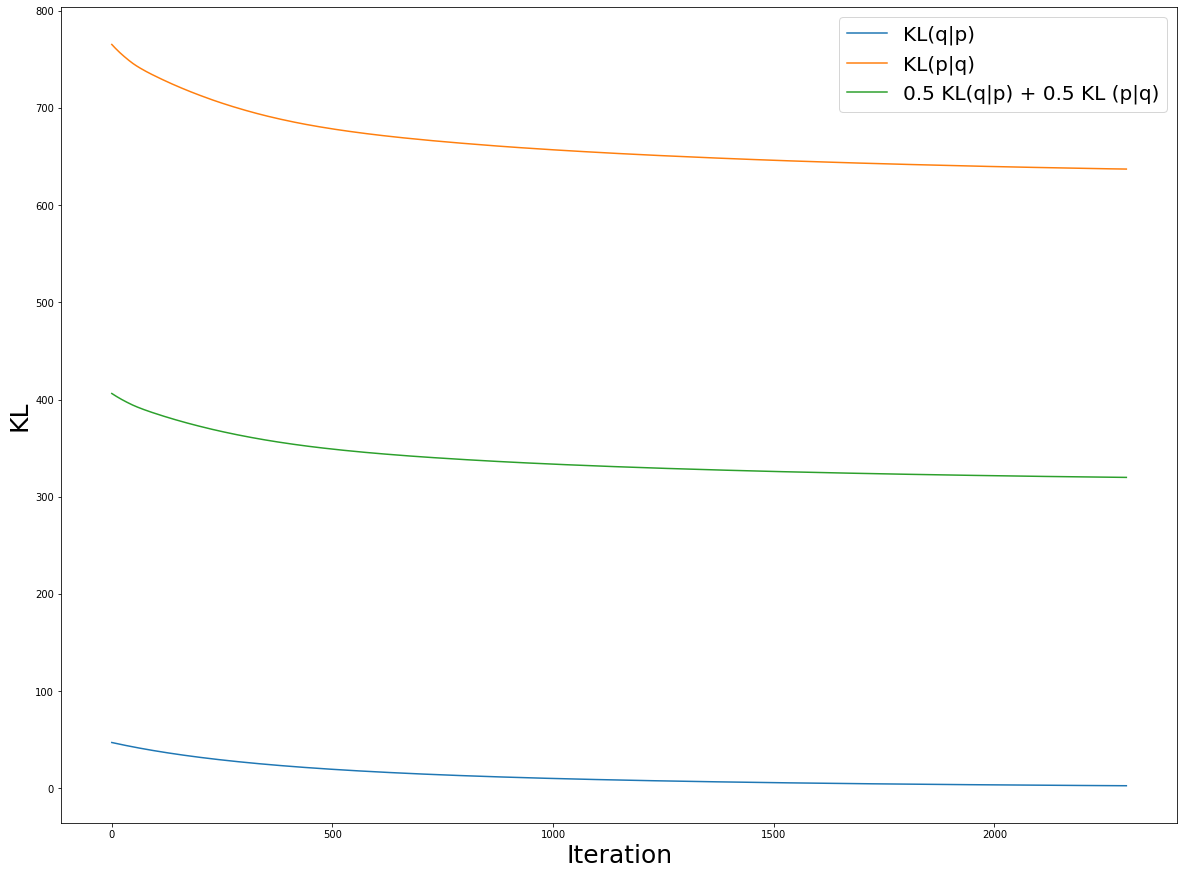

In [ ]:
plt.figure(figsize = (20,15))
plt.plot(pqKL, label = 'KL(q|p)')
plt.plot(qpKL, label = 'KL(p|q)')
plt.plot(half, label = '0.5 KL(q|p) + 0.5 KL (p|q)')
plt.legend(fontsize=20)
plt.xlabel('Iteration',fontsize=25)
plt.ylabel('KL',fontsize=25)

plt.show()